Imports and basic setup



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

device = torch.device("cpu")


Tiny scalar policy for Matching Pennies:
Each agent has one scalar logit.
Policy: π(H) = σ(logit), π(T) = 1 − π(H)

In [ ]:
class BernoulliPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        # scalar logit parameter
        self.logit = nn.Parameter(torch.zeros(()))

    def dist(self, batch_size):
        p = torch.sigmoid(self.logit)
        # expand to batch
        probs = p.expand(batch_size)
        return torch.distributions.Bernoulli(probs=probs)

    def prob_heads(self):
        with torch.no_grad():
            return torch.sigmoid(self.logit).item()


Matching Pennies payoff and exploitability helper
Payoff: +1 to player 1 if coins match, -1 otherwise. Player 2 gets the opposite.

We’ll also add a simple exploitability / NashConv calculator.

In [ ]:
def matching_pennies_payoff(p1, p2):
    """
    Expected payoff to player 1 when:
    - player1 plays Heads with prob p1
    - player2 plays Heads with prob p2
    """
    # u(p,q) = 4pq - 2p - 2q + 1  (derived)
    return 4*p1*p2 - 2*p1 - 2*p2 + 1


def matching_pennies_exploitability(p1, p2):
    """
    Approximate NashConv for Matching Pennies.
    NE is (0.5, 0.5) with value 0.
    We compute:
      - best response of player1 against p2 (pure H or T)
      - best response of player2 against p1 (pure H or T, minimizing u)
    and combine gaps.
    """
    # Player 1 best responses (p1 in {0,1})
    u_p1_H = matching_pennies_payoff(1.0, p2)
    u_p1_T = matching_pennies_payoff(0.0, p2)
    u_br1 = max(u_p1_H, u_p1_T)

    # Player 2 best responses (p2 in {0,1}) to MINIMIZE payoff to player1
    u_p2_H = matching_pennies_payoff(p1, 1.0)
    u_p2_T = matching_pennies_payoff(p1, 0.0)
    u_br2 = min(u_p2_H, u_p2_T)

    u_current = matching_pennies_payoff(p1, p2)

    # NashConv-style: gap for each player
    # Player1 gap: u(BR1, p2) - u(p1, p2)
    gap1 = u_br1 - u_current
    # Player2 gap: since u2 = -u1, best response gap becomes:
    # u2(p1, BR2) - u2(p1, p2) = -u(p1, BR2) + u(p1, p2)
    gap2 = -u_br2 + u_current

    return gap1 + gap2  # >= 0, =0 at Nash


Rollout: sample a batch of games
Each “episode” is just one simultaneous move.

In [ ]:
def rollout_batch(policy1, policy2, batch_size):
    """
    Sample a batch of Matching Pennies games from current policies.
    Returns:
      actions1, logp1_old, rewards1
      actions2, logp2_old, rewards2
    """
    with torch.no_grad():
        dist1 = policy1.dist(batch_size)
        dist2 = policy2.dist(batch_size)

        a1 = dist1.sample()          # 0 or 1
        a2 = dist2.sample()          # 0 or 1

        logp1 = dist1.log_prob(a1)
        logp2 = dist2.log_prob(a2)

        same = (a1 == a2).float()
        r1 = 2.0 * same - 1.0        # +1 if same, -1 otherwise
        r2 = -r1                     # zero-sum

    return a1, logp1, r1, a2, logp2, r2


4. PPO loss for a single agent (no value net, just centered reward as advantage)

Since episodes are one step, we can skip a value function and just use centered rewards.

In [ ]:
def ppo_loss(policy, actions, logp_old, rewards, clip_eps=0.2):
    """
    Basic PPO surrogate loss for one-step trajectories.
    advantage ≈ centered reward.
    """
    batch_size = actions.size(0)
    dist = policy.dist(batch_size)
    logp = dist.log_prob(actions)

    # normalized advantage
    adv = rewards - rewards.mean()
    adv = adv / (rewards.std() + 1e-8)

    ratio = torch.exp(logp - logp_old)
    surr1 = ratio * adv
    surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    loss = -torch.min(surr1, surr2).mean()
    return loss


5. Training loop with modes: "ppo" vs "oppo_last"

Modes:

"ppo": standard PPO

"oppo_last": O-PPO-Last using
(1 + ω)g_t - ωg_{t-1}

	​
"oppo_ema"


In [ ]:
def train_matching_pennies(
    mode="ppo",         # "ppo", "oppo_last", or "oppo_ema"
    num_iters=500,
    batch_size=1024,
    lr=0.05,
    omega=1.0,          # optimism coefficient
    beta=0.9,           # EMA decay for "oppo_ema"
):
    # two agents
    pi1 = BernoulliPolicy().to(device)
    pi2 = BernoulliPolicy().to(device)

    opt1 = optim.SGD(pi1.parameters(), lr=lr)
    opt2 = optim.SGD(pi2.parameters(), lr=lr)

    # buffers for optimistic gradients
    prev_grads1 = [torch.zeros_like(p) for p in pi1.parameters()]
    prev_grads2 = [torch.zeros_like(p) for p in pi2.parameters()]

    # EMA momentum buffers (for oppo_ema)
    mom1 = [torch.zeros_like(p) for p in pi1.parameters()]
    mom2 = [torch.zeros_like(p) for p in pi2.parameters()]

    probs1_history = []
    probs2_history = []
    exploit_history = []

    for it in range(num_iters):
        # 1. collect batch
        a1, logp1_old, r1, a2, logp2_old, r2 = rollout_batch(pi1, pi2, batch_size)

        # --------- update player 1 ---------
        opt1.zero_grad()
        loss1 = ppo_loss(pi1, a1, logp1_old, r1)
        loss1.backward()

        if mode == "ppo":
            opt1.step()

        elif mode == "oppo_last":
            # capture current gradient g_t
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi1.parameters()]

            # OGDA-style gradient: (1+ω)g_t - ω g_{t-1}
            for p, g_t, g_prev in zip(pi1.parameters(), cur_grads, prev_grads1):
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * g_prev
            opt1.step()
            prev_grads1 = cur_grads

        elif mode == "oppo_ema":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi1.parameters()]

            new_mom1 = []
            for p, g_t, m_prev in zip(pi1.parameters(), cur_grads, mom1):
                # m_t = (1 - beta) * g_t + beta * m_{t-1}
                m_t = (1.0 - beta) * g_t + beta * m_prev
                new_mom1.append(m_t)
                if p.grad is not None:
                    # optimistic gradient: (1+ω)g_t - ω m_t
                    p.grad = (1.0 + omega) * g_t - omega * m_t
            opt1.step()
            mom1 = new_mom1

        else:
            raise ValueError(f"Unknown mode {mode}")

        # --------- update player 2 (symmetric) ---------
        opt2.zero_grad()
        loss2 = ppo_loss(pi2, a2, logp2_old, r2)
        loss2.backward()

        if mode == "ppo":
            opt2.step()

        elif mode == "oppo_last":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi2.parameters()]
            for p, g_t, g_prev in zip(pi2.parameters(), cur_grads, prev_grads2):
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * g_prev
            opt2.step()
            prev_grads2 = cur_grads

        elif mode == "oppo_ema":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi2.parameters()]
            new_mom2 = []
            for p, g_t, m_prev in zip(pi2.parameters(), cur_grads, mom2):
                m_t = (1.0 - beta) * g_t + beta * m_prev
                new_mom2.append(m_t)
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * m_t
            opt2.step()
            mom2 = new_mom2

        # --------- logging ---------
        p1 = pi1.prob_heads()
        p2 = pi2.prob_heads()
        probs1_history.append(p1)
        probs2_history.append(p2)
        exploit_history.append(matching_pennies_exploitability(p1, p2))

        if (it + 1) % 50 == 0:
            print(f"iter {it+1:4d} | mode={mode} | p1(H)={p1:.3f}, p2(H)={p2:.3f}, "
                  f"exploit={exploit_history[-1]:.4f}")

    return {
        "p1_heads": probs1_history,
        "p2_heads": probs2_history,
        "exploitability": exploit_history,
        "pi1": pi1,
        "pi2": pi2,
    }


6. Run and visualize

First run PPO, then O-PPO to compare.

In [ ]:
# Baseline PPO
results_ppo = train_matching_pennies(
    mode="ppo",
    num_iters=400,
    batch_size=4096,
    lr=0.01,
)

# O-PPO-Last (OGDA-ish)
results_last = train_matching_pennies(
    mode="oppo_last",
    num_iters=400,
    batch_size=4096,
    lr=0.01,
    omega=1.0,
)

results_ema = train_matching_pennies(
    mode="oppo_ema",
    num_iters=400,
    batch_size=4096,
    lr=0.01,
    omega=0.5,
    beta=0.5,
)



iter   50 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0008
iter  100 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0008
iter  150 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0007
iter  200 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0009
iter  250 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0016
iter  300 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0018
iter  350 | mode=ppo | p1(H)=0.500, p2(H)=0.501, exploit=0.0020
iter  400 | mode=ppo | p1(H)=0.500, p2(H)=0.500, exploit=0.0015
iter   50 | mode=oppo_last | p1(H)=0.500, p2(H)=0.500, exploit=0.0005
iter  100 | mode=oppo_last | p1(H)=0.500, p2(H)=0.500, exploit=0.0003
iter  150 | mode=oppo_last | p1(H)=0.500, p2(H)=0.500, exploit=0.0001
iter  200 | mode=oppo_last | p1(H)=0.500, p2(H)=0.500, exploit=0.0008
iter  250 | mode=oppo_last | p1(H)=0.500, p2(H)=0.500, exploit=0.0011
iter  300 | mode=oppo_last | p1(H)=0.500, p2(H)=0.501, exploit=0.0018
iter  350 | mode=oppo_last | p1(H)=0.500, p2(H)=0.501, exploit=0.002

Plot probabilities and exploitability:

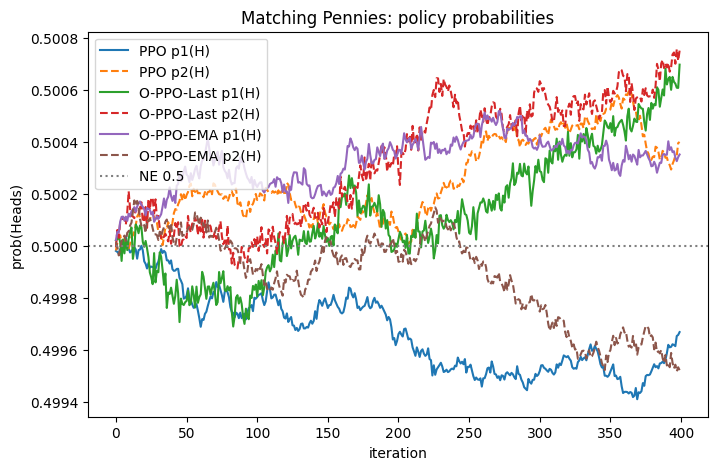

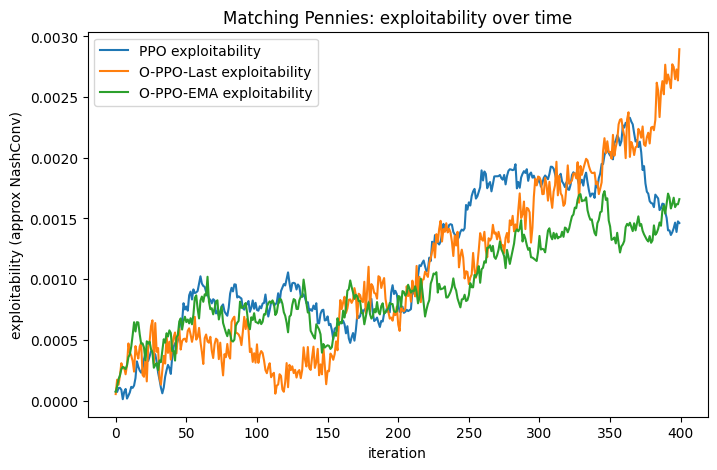

In [ ]:
def plot_results(results_ppo, results_last, results_ema):
    iters = range(len(results_ppo["p1_heads"]))

    # ----------------------
    # Policy probabilities
    # ----------------------
    plt.figure(figsize=(8,5))

    # PPO
    plt.plot(iters, results_ppo["p1_heads"], label="PPO p1(H)")
    plt.plot(iters, results_ppo["p2_heads"], label="PPO p2(H)", linestyle="--")

    # O-PPO-Last
    plt.plot(iters, results_last["p1_heads"], label="O-PPO-Last p1(H)")
    plt.plot(iters, results_last["p2_heads"], label="O-PPO-Last p2(H)", linestyle="--")

    # O-PPO-EMA
    plt.plot(iters, results_ema["p1_heads"], label="O-PPO-EMA p1(H)")
    plt.plot(iters, results_ema["p2_heads"], label="O-PPO-EMA p2(H)", linestyle="--")

    plt.axhline(0.5, linestyle=":", color="gray", label="NE 0.5")
    plt.xlabel("iteration")
    plt.ylabel("prob(Heads)")
    plt.title("Matching Pennies: policy probabilities")
    plt.legend()
    plt.show()

    # ----------------------
    # Exploitability
    # ----------------------
    plt.figure(figsize=(8,5))

    plt.plot(iters, results_ppo["exploitability"], label="PPO exploitability")
    plt.plot(iters, results_last["exploitability"], label="O-PPO-Last exploitability")
    plt.plot(iters, results_ema["exploitability"], label="O-PPO-EMA exploitability")

    plt.xlabel("iteration")
    plt.ylabel("exploitability (approx NashConv)")
    plt.title("Matching Pennies: exploitability over time")
    plt.legend()
    plt.show()

plot_results(results_ppo, results_last, results_ema)


Single-seed trainer


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train_matching_pennies(
    mode,              # "ppo", "oppo_last", "oppo_ema"
    num_iters,
    batch_size,
    lr,
    omega=1.0,
    beta=0.5,
    seed=None,
):
    """
    One training run of Matching Pennies self-play.

    Returns dict of numpy arrays:
      - p1_heads[t], p2_heads[t]
      - exploitability[t]
    """

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    pi1 = BernoulliPolicy().to(device)
    pi2 = BernoulliPolicy().to(device)

    opt1 = optim.SGD(pi1.parameters(), lr=lr)
    opt2 = optim.SGD(pi2.parameters(), lr=lr)

    # previous gradients for oppo_last
    prev_grads1 = [torch.zeros_like(p) for p in pi1.parameters()]
    prev_grads2 = [torch.zeros_like(p) for p in pi2.parameters()]

    # EMA buffers for oppo_ema
    mom1 = [torch.zeros_like(p) for p in pi1.parameters()]
    mom2 = [torch.zeros_like(p) for p in pi2.parameters()]

    p1_hist, p2_hist, exploit_hist = [], [], []

    for it in range(num_iters):
        a1, logp1_old, r1, a2, logp2_old, r2 = rollout_batch(pi1, pi2, batch_size)

        # ----- player 1 -----
        opt1.zero_grad()
        loss1 = ppo_loss(pi1, a1, logp1_old, r1)
        loss1.backward()

        if mode == "ppo":
            opt1.step()

        elif mode == "oppo_last":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi1.parameters()]
            for p, g_t, g_prev in zip(pi1.parameters(), cur_grads, prev_grads1):
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * g_prev
            opt1.step()
            prev_grads1 = cur_grads

        elif mode == "oppo_ema":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi1.parameters()]
            new_mom1 = []
            for p, g_t, m_prev in zip(pi1.parameters(), cur_grads, mom1):
                # m_t = (1 - beta) * g_t + beta * m_{t-1}
                m_t = (1.0 - beta) * g_t + beta * m_prev
                new_mom1.append(m_t)
                if p.grad is not None:
                    # optimistic gradient: (1+ω)g_t - ω m_t
                    p.grad = (1.0 + omega) * g_t - omega * m_t
            opt1.step()
            mom1 = new_mom1

        else:
            raise ValueError(f"Unknown mode {mode}")

        # ----- player 2 -----
        opt2.zero_grad()
        loss2 = ppo_loss(pi2, a2, logp2_old, r2)
        loss2.backward()

        if mode == "ppo":
            opt2.step()

        elif mode == "oppo_last":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi2.parameters()]
            for p, g_t, g_prev in zip(pi2.parameters(), cur_grads, prev_grads2):
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * g_prev
            opt2.step()
            prev_grads2 = cur_grads

        elif mode == "oppo_ema":
            with torch.no_grad():
                cur_grads = [p.grad.detach().clone() if p.grad is not None
                             else torch.zeros_like(p)
                             for p in pi2.parameters()]
            new_mom2 = []
            for p, g_t, m_prev in zip(pi2.parameters(), cur_grads, mom2):
                m_t = (1.0 - beta) * g_t + beta * m_prev
                new_mom2.append(m_t)
                if p.grad is not None:
                    p.grad = (1.0 + omega) * g_t - omega * m_t
            opt2.step()
            mom2 = new_mom2

        # logging
        p1 = pi1.prob_heads()
        p2 = pi2.prob_heads()
        p1_hist.append(p1)
        p2_hist.append(p2)
        exploit_hist.append(matching_pennies_exploitability(p1, p2))

    return {
        "p1_heads": np.array(p1_hist),
        "p2_heads": np.array(p2_hist),
        "exploitability": np.array(exploit_hist),
    }

Multi-seed runner

In [ ]:
def run_multi_seed(
    mode,
    num_seeds,
    num_iters,
    batch_size,
    lr,
    omega=1.0,
    beta=0.5,
    base_seed=0,
):
    """
    Run `num_seeds` independent seeds for a given mode.
    Returns dict with arrays of shape [num_seeds, num_iters].
    """
    all_p1 = []
    all_p2 = []
    all_exploit = []

    for s in range(num_seeds):
        seed = base_seed + s
        res = train_matching_pennies(
            mode=mode,
            num_iters=num_iters,
            batch_size=batch_size,
            lr=lr,
            omega=omega,
            beta=beta,
            seed=seed,
        )
        all_p1.append(res["p1_heads"])
        all_p2.append(res["p2_heads"])
        all_exploit.append(res["exploitability"])

    return {
        "p1_heads": np.stack(all_p1, axis=0),      # [seeds, iters]
        "p2_heads": np.stack(all_p2, axis=0),
        "exploitability": np.stack(all_exploit, 0),
    }


Run PPO / O-PPO-Last / O-PPO-EMA with shared hyperparams

In [ ]:
num_iters = 400
num_seeds = 10
batch_size = 4096

# shared learning rate for fair comparison
lr_shared = 0.01

results_ppo = run_multi_seed(
    mode="ppo",
    num_seeds=num_seeds,
    num_iters=num_iters,
    batch_size=batch_size,
    lr=lr_shared,
)

results_last = run_multi_seed(
    mode="oppo_last",
    num_seeds=num_seeds,
    num_iters=num_iters,
    batch_size=batch_size,
    lr=lr_shared,
    omega=1.0,
)

results_ema = run_multi_seed(
    mode="oppo_ema",
    num_seeds=num_seeds,
    num_iters=num_iters,
    batch_size=batch_size,
    lr=lr_shared,
    omega=0.5,
    beta=0.5,
)

Plotting template: mean ± std for distance to NE and exploitability

In [ ]:
def plot_mean_std(all_results, labels, title_suffix=""):
    """
    all_results: list of dicts from run_multi_seed
    labels:      list of strings, same length
    """
    iters = np.arange(all_results[0]["p1_heads"].shape[1])

    # ---------- distance to NE ----------
    plt.figure(figsize=(7, 4))
    for res, label in zip(all_results, labels):
        p1 = res["p1_heads"]   # [seeds, iters]
        p2 = res["p2_heads"]
        dist = np.abs(p1 - 0.5) + np.abs(p2 - 0.5)   # [seeds, iters]

        mean = dist.mean(axis=0)
        std = dist.std(axis=0)

        plt.plot(iters, mean, label=label)
        plt.fill_between(iters, mean - std, mean + std, alpha=0.2)
    plt.xlabel("iteration")
    plt.ylabel(r"$|p_1-0.5| + |p_2-0.5|$")
    plt.title("Distance to Nash equilibrium" + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- exploitability ----------
    plt.figure(figsize=(7, 4))
    for res, label in zip(all_results, labels):
        ex = res["exploitability"]   # [seeds, iters]
        mean = ex.mean(axis=0)
        std = ex.std(axis=0)

        plt.plot(iters, mean, label=label)
        plt.fill_between(iters, mean - std, mean + std, alpha=0.2)
    plt.xlabel("iteration")
    plt.ylabel("exploitability (approx NashConv)")
    plt.title("Exploitability over time" + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()


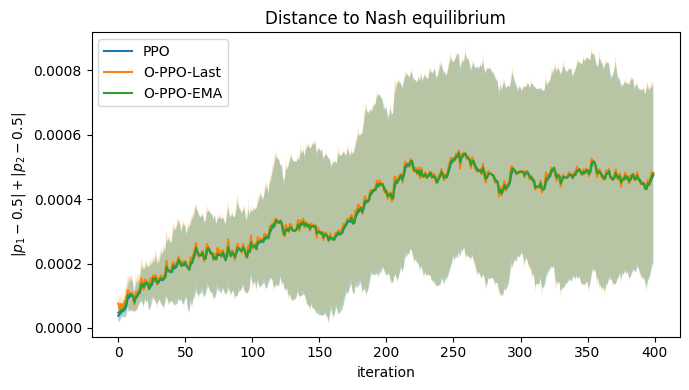

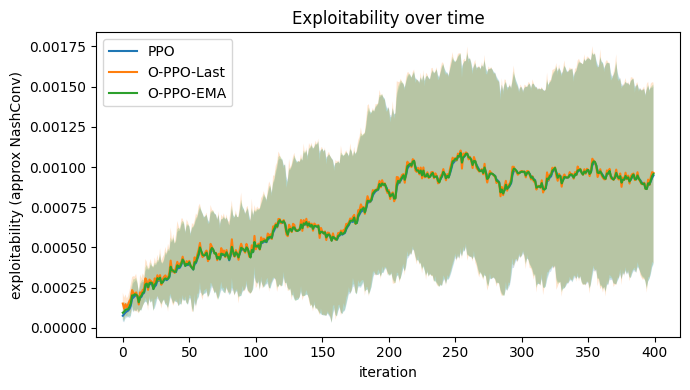

In [ ]:
plot_mean_std(
    [results_ppo, results_last, results_ema],
    ["PPO", "O-PPO-Last", "O-PPO-EMA"],
)
